## Dyna Q algorithm

This time we will use [Taxi](https://gymnasium.farama.org/environments/toy_text/taxi/) environment from the [<tt>Gymnasium</tt>](https://gymnasium.farama.org/index.html):

In [1]:
using ReinforcementLearningBase, ReinforcementLearningEnvironments
using PyCall, Images, Plots

After installing [<tt>gymnasium</tt>](https://github.com/Farama-Foundation/Gymnasium) package we can import it:

In [2]:
gym = pyimport("gymnasium")

PyObject <module 'gymnasium' from 'C:\\Users\\barto\\AppData\\Roaming\\Python\\Python312\\site-packages\\gymnasium\\__init__.py'>

and create an environment:

In [3]:
env = gym.make("Taxi-v3", render_mode="rgb_array")
env.reset()

(3, Dict{Any, Any}("action_mask" => Int8[1, 0, 1, 0, 1, 0], "prob" => 1.0))

In [4]:
mutable struct TaxiEnv <: AbstractEnv
    PyEnv::PyObject
    action_space::UnitRange{Int64}
    state_space::UnitRange{Int64}
    state::Int 
    reward::Union{Nothing, Float64} 
    done::Bool
end
Main.TaxiEnv

TaxiEnv

In [5]:
function TaxiEnv() 
    gym = pyimport("gymnasium")
    env = gym.make("Taxi-v3", render_mode="rgb_array")
    state, _ = env.reset()
    state_space = 0:(py"int($env.observation_space.n)"-1)
    action_space = 0:(py"int($env.action_space.n)"-1)
    return TaxiEnv(env, action_space, state_space, state, nothing, false)
end

TaxiEnv

In [6]:
#functions:
RLBase.action_space(env::TaxiEnv) = env.action_space
RLBase.state_space(env::TaxiEnv) = env.state_space
RLBase.reward(env::TaxiEnv) = env.reward
RLBase.state(env::TaxiEnv, ::Observation, ::DefaultPlayer) = env.state
RLBase.is_terminated(env::TaxiEnv) = env.done
function RLBase.reset!(env::TaxiEnv) 
    env.state, _ = env.PyEnv.reset()
    env.reward = nothing
    env.done = false
    nothing
end

In [7]:
function RLBase.act!(env::TaxiEnv, action)
    @assert action in action_space(env)
    env.state, env.reward, env.done, _, _ = env.PyEnv.step(action)
    nothing
end

In [8]:
function render(env::TaxiEnv)
    img = reinterpretc(RGB{N0f8}, PermutedDimsArray(env.PyEnv.render(), (3, 1, 2)));
    display(img) 
end

render (generic function with 1 method)

In [9]:
env = TaxiEnv()

# TaxiEnv

## Traits

| Trait Type        |                  Value |
|:----------------- | ----------------------:|
| NumAgentStyle     |          SingleAgent() |
| DynamicStyle      |           Sequential() |
| InformationStyle  | ImperfectInformation() |
| ChanceStyle       |           Stochastic() |
| RewardStyle       |           StepReward() |
| UtilityStyle      |           GeneralSum() |
| ActionStyle       |     MinimalActionSet() |
| StateStyle        |     Observation{Any}() |
| DefaultStateStyle |     Observation{Any}() |
| EpisodeStyle      |             Episodic() |

## Is Environment Terminated?

No

## State Space

`0:499`

## Action Space

`0:5`

## Current State

```
53
```


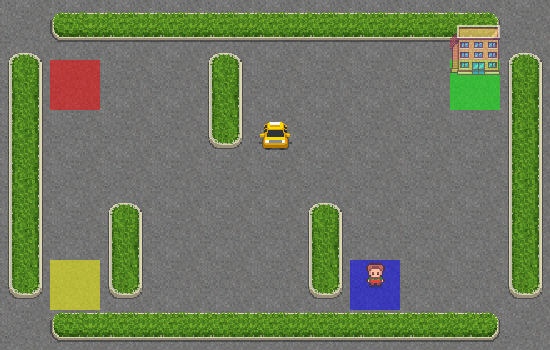

nothing

In [10]:
for i = 1:100
    IJulia.clear_output(true)
    act!(env, rand(action_space(env)))
    render(env) |> IJulia.display
end

Now, we will define agent (note how it differs from the basic TD learning):

In [16]:
mutable struct Agent
    env::AbstractEnv
    ϵ::Float64 #współczynnik eksploracji
    ϵ_decay::Float64
    ϵ_min::Float64
    β::Float64 #dyskonto
    α::Float64 #stopa uczenia się
    planning::Int64 #liczba krokow planowania
    Q::Dict
    model::Dict
    steps_per_episode::Vector{Float64} #ile trwal kazdy z epizodow
    rewards_per_episode::Vector{Float64} #nagroda w kazdym z epizodow
end

function Agent(planning_steps; ϵ = 1.0, ϵ_decay = 0.9975, ϵ_min = 0.005,
        β = 0.99, α = 0.1) 
    Agent(TaxiEnv(), 
        ϵ, ϵ_decay, ϵ_min, β, α, planning_steps,
        Dict(), Dict(), [], [])
end

Agent

It is time to define the model approximation function. In our case it is simple, usually it is far more complicated:

In [12]:
feed!(agent,state, action, reward, new_state) = (agent.model[(state,action)] = (new_state, reward))

feed! (generic function with 1 method)

Learning function:

In [13]:
function learn!(agent, state, action, reward, new_state)
    if !haskey(agent.Q, state)
        agent.Q[state] = zeros(length(action_space(agent.env)))
        agent.Q[state][action] = reward
    else
        Q_next_state = 0.0
        haskey(agent.Q, new_state) && ( Q_next_state += maximum(agent.Q[new_state]))
        agent.Q[state][action] += agent.α * (reward + agent.β*Q_next_state - agent.Q[state][action])
    end
    
end

learn! (generic function with 1 method)

Finally, main loop:

In [18]:
function dyna_Q!(agent, steps; burning = true, 
        animated = false) 
    step = 0.0
    steps_per_episode = 0.0
    total_reward = 0.0
    episode = 1.0
    if animated
        IJulia.clear_output(true)
        render(agent.env) |> IJulia.display
    end
    while step <= steps
        S = deepcopy(state(agent.env))
        if (burning && step < 0.1*steps) || rand() < agent.ϵ || !haskey(agent.Q, state(agent.env))
            A = rand(1:length(action_space(agent.env)))
        else 
            A = argmax(agent.Q[state(agent.env)])
        end
        act!(agent.env,action_space(agent.env)[A])
        r = reward(agent.env)
        total_reward += r
        S′ = deepcopy(state(agent.env))
        learn!(agent, S, A, r, S′)
        feed!(agent, S, A, r, S′)
        for i = 1:agent.planning
            (S,a),(S′, R) = rand(agent.model)
            learn!(agent, S, a, R, S′)
        end 
        if animated
            IJulia.clear_output(true)
            render(agent.env) |> IJulia.display
        end
        if is_terminated(agent.env)
            eps = agent.ϵ * agent.ϵ_decay
            agent.ϵ = max(agent.ϵ_min, eps)
            push!(agent.rewards_per_episode, total_reward)
            push!(agent.steps_per_episode, steps_per_episode)
            episode += 1.0
            total_reward = 0.0
            steps_per_episode = 0
            reset!(agent.env)
        end
        step += 1.0 
        steps_per_episode += 1.0
    end
end

dyna_Q! (generic function with 1 method)

Let us test if everything works. DynaQ before learning:

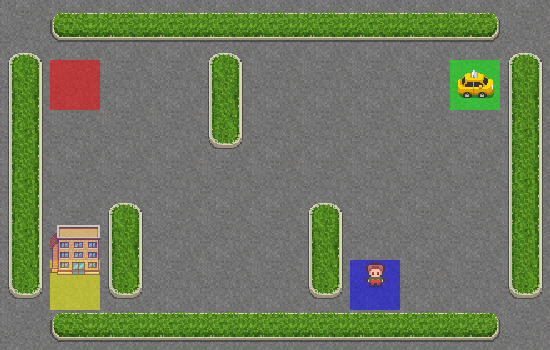

nothing

In [19]:
agent = Agent(5);

dyna_Q!(agent, 100, animated = true)

and after learning:

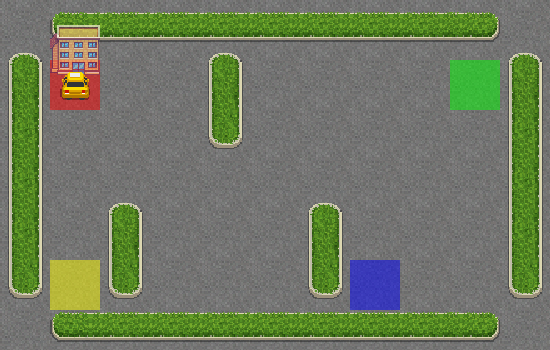

nothing

In [21]:
dyna_Q!(agent, 250_000)
dyna_Q!(agent, 200, burning = false, animated = true)

Now, let us take a look at the impact of planning steps number:

In [25]:
@info "agent 0 steps of planning (Q-learning)"
agent = Agent(0);
@time dyna_Q!(agent, 1_000_000)
@info "agent number of episodes: $(length(agent.rewards_per_episode))"

@info "agent 10 steps of planning"
agent = Agent(10);
@time dyna_Q!(agent, 1_000_000)
@info "agent number of episodes: $(length(agent.rewards_per_episode))"

@info "agent 30 steps of planning"
agent = Agent(30);
@time dyna_Q!(agent, 1_000_000)
@info "agent number of episodes: $(length(agent.rewards_per_episode))"

[ Info: agent 0 steps of planning (Q-learning)


 46.085833 seconds (122.40 M allocations: 3.881 GiB, 3.42% gc time)


[ Info: agent number of episodes: 64908
[ Info: agent 10 steps of planning


 59.672464 seconds (352.52 M allocations: 8.804 GiB, 3.79% gc time)


[ Info: agent number of episodes: 67178
[ Info: agent 30 steps of planning


 81.266887 seconds (812.46 M allocations: 18.638 GiB, 4.32% gc time)


[ Info: agent number of episodes: 67395


### Experiment

<i>Score for different numbers of planning steps:</i>

In [41]:
#Warning! This experiment is pretty slow!

using Random; Random.seed!(234)

res = []
times = []
for plan_steps in 0:1:15
    avg_scores = []
    times_steps = []
    for j in 1:5
        agent = Agent(plan_steps);
        t = @elapsed dyna_Q!(agent, 100_000)
        push!(avg_scores, sum(agent.rewards_per_episode)/length(agent.rewards_per_episode))
        push!(times_steps, t)
    end
    push!(res,sum(avg_scores)/length(avg_scores))
    push!(times,sum(times_steps)/length(times_steps))
end

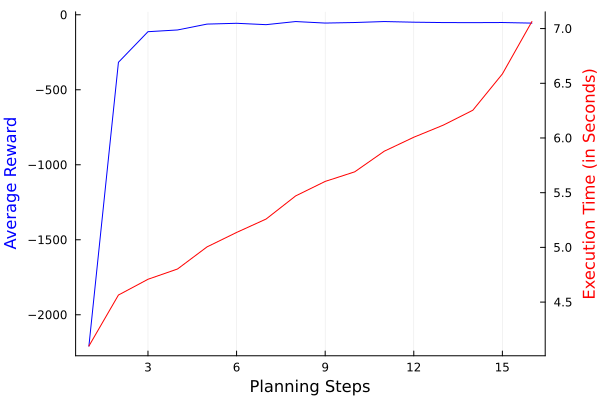

In [42]:
plot(res, color = "blue", legend = false, xlabel = "Planning Steps", ylabel = "Average Reward", yguidefontcolor=:blue)
plot!(twinx(), times, color = "red", legend = false, ylabel = "Execution Time (in Seconds)", yguidefontcolor=:red)